In [1]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [3]:
import sys
import logging
import datetime

nblog = open("./output/catboost_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

In [5]:
%%time

df_traffic = pd.read_csv('./output/austin_2022_GP_10min_interval_delaydifference_with_features_forML.csv')
df_traffic['minutes_since_midnight'] = df_traffic['hour_min'].apply(lambda x: int(x[:2]) * 60 + int(x[3:]))

print(df_traffic.date.unique())
print('unique road segments (samples):',df_traffic.tmc_code.unique().shape[0])
print('total observations: ',df_traffic.shape[0])
df_traffic.head(2)

['2022-10-21' '2022-10-22' '2022-10-23']
unique road segments (samples): 4450
total observations:  1917950
CPU times: user 8.07 s, sys: 10.1 s, total: 18.2 s
Wall time: 4min 57s


,tmc_code,hour_min,delay_baseline,delay_focus,delay_difference,date,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles,airbnb_count,distance_to_Shuttle_Waterloo_Park,distance_to_Shuttle_Barton_Creek_Square,distance_to_Shuttle_Expo_Center,distance_to_Uber_DelValle_HighSchool,distance_to_venue,minutes_since_midnight
0,112+04758,00:00,-0.93268,-0.93268,0.00000,2022-10-21,51ST ST/CAMERON RD/EXIT 237,30.30330,-97.71418,30.30530,-97.71289,0.15814,87,4685.01085,11838.72611,10171.97090,19603.37763,23552.59734,0
1,112+04758,00:10,-0.93268,-0.93268,0.00000,2022-10-21,51ST ST/CAMERON RD/EXIT 237,30.30330,-97.71418,30.30530,-97.71289,0.15814,87,4685.01085,11838.72611,10171.97090,19603.37763,23552.59734,10


In [44]:
# because the event usually begins in the morning after 10, people arrive typically around that time, so we want to only focus on after 930
df_traffic = df_traffic[df_traffic['minutes_since_midnight']>=540]
print(df_traffic.shape[0])

1197050


In [45]:
df_traffic.columns

Index(['tmc_code', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'date', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'miles', 'airbnb_count', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'distance_to_Uber_DelValle_HighSchool', 'distance_to_venue', 'minutes_since_midnight'], dtype='object')

CPU times: user 441 ms, sys: 27.7 ms, total: 469 ms
Wall time: 586 ms


,minutes_since_midnight,start_latitude,start_longitude,airbnb_count,distance_to_Shuttle_Waterloo_Park,distance_to_Shuttle_Barton_Creek_Square,distance_to_Shuttle_Expo_Center,distance_to_Uber_DelValle_HighSchool,distance_to_venue
minutes_since_midnight,1.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000
start_latitude,-0.00000,16.14387,-0.44855,0.32878,3.20028,-0.56525,0.53678,30.31106,-45.99889
start_longitude,-0.00000,-0.44855,5.26752,-0.34816,-0.66593,-5.81813,-0.41620,17.44346,-12.34132
airbnb_count,0.00000,0.32878,-0.34816,1.69176,5.86380,-3.08513,-2.44986,1.32043,-1.60832
distance_to_Shuttle_Waterloo_Park,0.00000,3.20028,-0.66593,5.86380,73.60627,-50.29743,-22.60391,-16.50960,11.51444
distance_to_Shuttle_Barton_Creek_Square,-0.00000,-0.56525,-5.81813,-3.08513,-50.29743,46.38774,10.13741,15.66321,-18.21474
distance_to_Shuttle_Expo_Center,-0.00000,0.53678,-0.41620,-2.44986,-22.60391,10.13741,30.04412,-80.50772,68.03208
distance_to_Uber_DelValle_HighSchool,-0.00000,30.31106,17.44346,1.32043,-16.50960,15.66321,-80.50772,484.33403,-450.50630
distance_to_venue,0.00000,-45.99889,-12.34132,-1.60832,11.51444,-18.21474,68.03208,-450.50630,445.12128


In [57]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare input features and labels for the model
X = df_traffic[['minutes_since_midnight',  'date', 'start_latitude', 'start_longitude', 'date',
                          'airbnb_count', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 
                          'distance_to_Shuttle_Expo_Center', 'distance_to_Uber_DelValle_HighSchool', 'distance_to_venue']].copy()
y = df_traffic['delay_difference'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Total sample size:', X.shape[0])
print('Total training set size:', X_train.shape[0])
print('Total test set size:', X_test.shape[0])

Total sample size: 1197050
Total training set size: 837935
Total test set size: 359115


In [61]:
%%time
# check VIF
df_cor = X.corr()
pd.DataFrame(np.linalg.inv(X.corr().values), index = df_cor.index, columns=df_cor.columns)

CPU times: user 445 ms, sys: 57 ms, total: 502 ms
Wall time: 491 ms


,minutes_since_midnight,start_latitude,start_longitude,airbnb_count,distance_to_Shuttle_Waterloo_Park,distance_to_Shuttle_Barton_Creek_Square,distance_to_Shuttle_Expo_Center,distance_to_Uber_DelValle_HighSchool,distance_to_venue
minutes_since_midnight,1.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000
start_latitude,-0.00000,16.14387,-0.44855,0.32878,3.20028,-0.56525,0.53678,30.31106,-45.99889
start_longitude,-0.00000,-0.44855,5.26752,-0.34816,-0.66593,-5.81813,-0.41620,17.44346,-12.34132
airbnb_count,0.00000,0.32878,-0.34816,1.69176,5.86380,-3.08513,-2.44986,1.32043,-1.60832
distance_to_Shuttle_Waterloo_Park,0.00000,3.20028,-0.66593,5.86380,73.60627,-50.29743,-22.60391,-16.50960,11.51444
distance_to_Shuttle_Barton_Creek_Square,-0.00000,-0.56525,-5.81813,-3.08513,-50.29743,46.38774,10.13741,15.66321,-18.21474
distance_to_Shuttle_Expo_Center,-0.00000,0.53678,-0.41620,-2.44986,-22.60391,10.13741,30.04412,-80.50772,68.03208
distance_to_Uber_DelValle_HighSchool,-0.00000,30.31106,17.44346,1.32043,-16.50960,15.66321,-80.50772,484.33403,-450.50630
distance_to_venue,0.00000,-45.99889,-12.34132,-1.60832,11.51444,-18.21474,68.03208,-450.50630,445.12128


In [62]:
# %%time
# df_features = df_traffic[['minutes_since_midnight',  'date', 'start_latitude', 'start_longitude', 
#                           'airbnb_count', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 
#                           'distance_to_Shuttle_Expo_Center', 'distance_to_Uber_DelValle_HighSchool', 'distance_to_venue']]

# categorical_list = ['date']

# X = df_features
# y = df_traffic.delay_difference

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# # X_train.dtypes

# import catboost as cb

# train_dataset = cb.Pool(X_train, y_train, cat_features=categorical_list)
# test_dataset = cb.Pool(X_test, y_test, cat_features=categorical_list)

# print(train_dataset.shape[0])
# print(test_dataset.shape[0])

# Hyperparameter tuning using optuna

In [ ]:
# %%time
# # %pip install optuna
# ## this step took 10 hours to finish

# import optuna
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import make_scorer, mean_squared_error

# def objective(trial):
#     # Define hyperparameters to optimize
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1200, step=100),
#         'max_depth': trial.suggest_int('depth', 4, 12),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#         'loss_function': 'RMSE','eval_metric': 'RMSE'
#     }

#     # Initialize CatBoostRegressor with the suggested hyperparameters
#     model = cb.CatBoostRegressor(cat_features=categorical_list, **params, verbose=0)
    
#     # Perform cross-validation
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
# #     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
#     rmse_scorer = make_scorer(mean_squared_error, squared=False)
#     scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)

#     return scores.mean()

# # Create a study and optimize the objective function
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# Training

In [59]:
# %%time
# # takes ~3min
# print(datetime.datetime.now(),'*************** Start running CatBoostRegressor ***************')

# # best_params = study.best_trial.params
# # best_params = {'iterations': 1200, 'depth': 11, 'learning_rate': 0.23142508586634666, 'colsample_bylevel': 0.09979649240941614, 
# #                'subsample': 0.9448024344511282, 'min_data_in_leaf': 67}

# regressor = cb.CatBoostRegressor(
#     custom_metric= ['R2', 'RMSE'], early_stopping_rounds=50)
# regressor.fit(train_dataset, eval_set = test_dataset)

# output_path = './output/current_catboost_' + str(datetime.datetime.now())
# regressor.save_model(output_path)

# print(datetime.datetime.now(),'*************** Done running CatBoostRegressor ***************')

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


# Define model parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'n_estimators': 100
}

# Train model using DMatrix
model = xgb.train(params, dtrain, num_boost_round=100,
                  evals=[(dtest, 'eval')],
                  early_stopping_rounds=50)

# Make predictions
y_pred = model.predict(dtest)

# Model evaluation

In [51]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(datetime.datetime.now(),'Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print(datetime.datetime.now(),'Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# Best Model RMSE: 0.193
# Best Model R-squared: 0.631

2024-11-13 10:13:42.374456 Best Model RMSE: 15.852
2024-11-13 10:13:42.389907 Best Model R-squared: 0.365
CPU times: user 2.61 s, sys: 32.3 ms, total: 2.64 s
Wall time: 214 ms


# SHAP

In [52]:
%%time
#  ~1min
import shap

print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X)
print(datetime.datetime.now(),'*************** Done running SHAP ***************')

2024-11-13 10:13:42.398173 *************** Start running SHAP ***************
2024-11-13 10:14:11.210126 *************** Done running SHAP ***************
CPU times: user 4min 52s, sys: 4.08 s, total: 4min 56s
Wall time: 28.8 s


2024-11-13 10:14:11.218715 *************** Start running SHAP importance ***************
2024-11-13 10:14:17.996363 *************** Done running SHAP importance ***************
CPU times: user 6.68 s, sys: 88.7 ms, total: 6.77 s
Wall time: 6.78 s


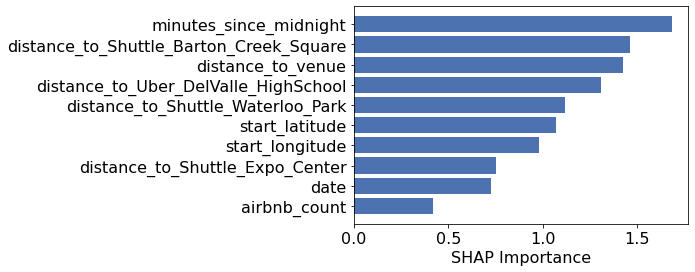

In [53]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1)  #,figsize=(6,9)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color="#4c72b0") #'turquoise'
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('SHAP Importance')
# plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')